<a href="https://colab.research.google.com/github/mlopes96/desafio-dio-transfer-learning-com-python/blob/main/transfer_learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de Redes Neurais com Transfer Learning
Desafio para a Formação Machine Learning da DIO, sobre Treinamento de Redes Neurais com Transfer Learning, usando Python.

Inicia pela importação das bibliotecas e a conexão com o Drive

In [ ]:
# Inicia importando as bibliotecas
import tensorflow as tf
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2

In [ ]:
# Faz a conexão com o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Caminho para a pasta onde estão as imagens
path = f'/content/drive/MyDrive/Colab Notebooks/TransferLearning/cat_dog'

# Imagens de Teste
test_set = f'{path}/test_set'

# Imagens de Treinamento
training_set = f'{path}/training_set'


Confere as informações das imagens carregadas

In [ ]:
# Carrega uma imagem de treinamento de amostra
imagem_exemplo = cv2.imread(f'{training_set}/dog/dog.100.jpg')

# Obtém as dimensões da imagem
altura, largura, canais_de_cor = imagem_exemplo.shape

print("Altura:", altura)
print("Largura:", largura)
print("Canais de Cor:", canais_de_cor)

Altura: 397
Largura: 500
Canais de Cor: 3


Separa e pré-processa os dados de treinamento e de teste

In [ ]:
# Carrega e pré-processa os dados de treinamento e teste
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(training_set,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_set,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Carrega o modelo de rede neural MobileNetV2 e faz o treinamento da rede

In [ ]:
# Carrega o modelo MobileNetV2 pré-treinado e remove a camada de saída original
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224,224,3))

# Congela todas as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False


# Cria um novo modelo que consiste no modelo base MobileNetV2 seguido por algumas camadas personalizadas
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(640, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(640, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(head_model)
head_model = Dropout(0.2)(head_model)
predictions = Dense(1, activation='sigmoid')(head_model) # Camada de saída binária

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compila o modelo e o treina usando os dados de treinamento.
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch=len(train_generator),
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

Epoch 1/10
125/125 [==============================] - 734s 6s/step - loss: 9.2086 - accuracy: 0.9582 - val_loss: 1.8146 - val_accuracy: 0.9520
Epoch 2/10
125/125 [==============================] - 163s 1s/step - loss: 0.7543 - accuracy: 0.9790 - val_loss: 0.3822 - val_accuracy: 0.9530
Epoch 3/10
125/125 [==============================] - 151s 1s/step - loss: 0.2068 - accuracy: 0.9775 - val_loss: 0.1752 - val_accuracy: 0.9660
Epoch 4/10
125/125 [==============================] - 155s 1s/step - loss: 0.1317 - accuracy: 0.9810 - val_loss: 0.1312 - val_accuracy: 0.9780
Epoch 5/10
125/125 [==============================] - 162s 1s/step - loss: 0.1120 - accuracy: 0.9818 - val_loss: 0.1253 - val_accuracy: 0.9780
Epoch 6/10
125/125 [==============================] - 167s 1s/step - loss: 0.1213 - accuracy: 0.9795 - val_loss: 0.1305 - val_accuracy: 0.9700
Epoch 7/10
125/125 [==============================] - 160s 1s/step - loss: 0.1087 - accuracy: 0.9840 - val_loss: 0.1257 - val_accuracy: 0.9800

Faz a avaliação padrão da rede treinada

32/32 [==============================] - 32s 991ms/step - loss: 0.1130 - accuracy: 0.9770
Acurácia no conjunto de teste: 0.9769999980926514


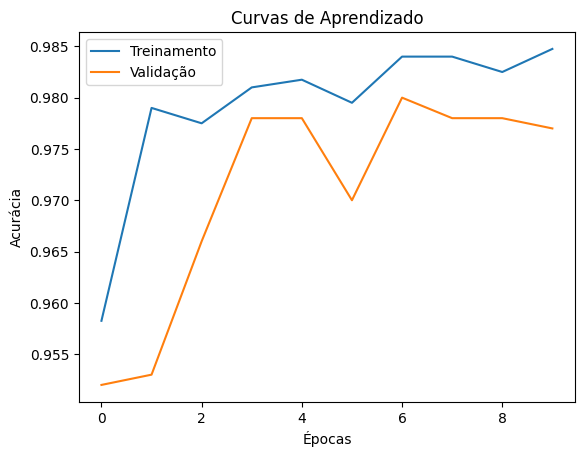

In [ ]:
# Após o treinamento, o modelo é avaliado para visualizar suas métricas de desempenho
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Acurácia no conjunto de teste: {test_accuracy}")

# Plota as curvas de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curvas de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

Gera a matriz de confusão dos acertos e erros do algoritmo

In [ ]:
# Realiza as previsões no conjunto de teste usando o modelo treinado
predictions = model.predict(test_generator)

# Utiliza um limiar adequado de 0.5 para classificação binária
y_pred = (predictions > 0.5).astype(int)

# Obtém os rótulos verdadeiros do conjunto de teste
y_true = test_generator.classes

# Calcula a matriz de confusão
confusion = confusion_matrix(y_true, y_pred)

32/32 [==============================] - 33s 985ms/step


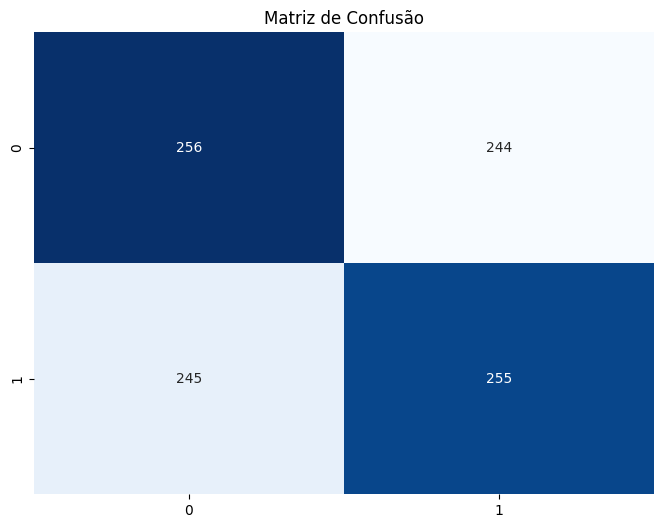

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crie um gráfico da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.show()

Realiza os Cálculo das Métricas de Avaliação de Aprendizado

In [ ]:
# Extrai os valores da matriz de confusão
VP = confusion[1, 1]  # Verdadeiros Positivos
VN = confusion[0, 0]  # Verdadeiros Negativos
FP = confusion[0, 1]  # Falsos Positivos
FN = confusion[1, 0]  # Falsos Negativos

# Faz o cálculo das métricas de avaliação
acuracia = (VP + VN) / (VP + VN + FP + FN)
sensibilidade = VP / (VP + FN)
especificidade = VN / (VN + FP)
precisao = VP / (VP + FP)
fscore = 2 * (precisao * sensibilidade) / (precisao + sensibilidade)

# Imprime as métricas
print("Acurácia:", acuracia)
print("Sensibilidade:", sensibilidade)
print("Especificidade:", especificidade)
print("Precisão:", precisao)
print("F-score:", fscore)

Acurácia: 0.511
Sensibilidade: 0.51
Especificidade: 0.512
Precisão: 0.5110220440881763
F-score: 0.5105105105105106


Exporta o modelo da rede que foi treinada

In [19]:
# Salva a arquitetura do modelo em um arquivo JSON
model_json = model.to_json()
with open("model_cats_dogs.json", "w") as json_file:
    json_file.write(model_json)

# Salva os pesos do modelo em um arquivo HDF5
model.save_weights("weights_cats_dogs.h5")

Carrega o modelo da rede

In [20]:
# Carrega a arquitetura do modelo a partir do arquivo JSON
with open("model_cats_dogs.json", "r") as json_file:
    model_json = json_file.read()
model_load = model_from_json(model_json)

# Carrega os pesos do modelo a partir do arquivo HDF5
model_load.load_weights("weights_cats_dogs.h5")

Carrega uma imagem de um cachorro e faz a predição

In [21]:
# Carrega a imagem
imagem1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/TransferLearning/Labrador.jpg')

# Pré-processa a imagem para corresponder ao formato de entrada do modelo
imagem1 = cv2.resize(imagem1, (224, 224))

# Normaliza os valores dos pixels
imagem1 = imagem1 / 255.0

# Fazer previsões com o modelo carregado
previsao = model_load.predict(np.expand_dims(imagem1, axis=0))

# Interpretar a previsão (se é um gato ou um cachorro)
if previsao[0][0] > 0.5:
    classe_prevista = "Cachorro"
else:
    classe_prevista = "Gato"

print(f"A imagem é um(a) {classe_prevista}.")

1/1 [==============================] - 3s 3s/step
A imagem é um(a) Cachorro.


Carrega uma imagem de um gato e faz a predição

In [22]:
# Carrega a imagem
imagem2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/TransferLearning/Gato.jpg')

# Pré-processa a imagem para corresponder ao formato de entrada do modelo
imagem2 = cv2.resize(imagem2, (224, 224))

# Normaliza os valores dos pixels
imagem2 = imagem2 / 255.0

# Fazer previsões com o modelo carregado
previsao = model_load.predict(np.expand_dims(imagem2, axis=0))

# Interpretar a previsão (se é um gato ou um cachorro)
if previsao[0][0] > 0.5:
    classe_prevista = "Cachorro"
else:
    classe_prevista = "Gato"

print(f"A imagem é um(a) {classe_prevista}.")

1/1 [==============================] - 0s 43ms/step
A imagem é um(a) Gato.
